# Bench Press Predictor
The goal of this project is to predict how much an individual could bench press (1 rep max) based on their sex, weight class, squat max, and many other features.

## Dataset
This dataset is a snapshot of the OpenPowerlifting database as of April 2019. OpenPowerlifting is creating a public-domain archive of powerlifting history. Powerlifting is a sport in which competitors compete to lift the most weight for their class in three separate barbell lifts: the Squat, Bench, and Deadlift.

## Content
The data is represented by openpowerlifting.csv, which includes all information on the meets (competitions) as well as the competitors who attended those meets.

### Column Definitions
**Events** -> The lifts competed in. Squat, Bench, Deadlift (SBD) is the standard three powerlifts, but competitors may do only some of the lifts.

**Equipment** - The type of equipment that was worn. Federations may break competition down by different equipment.

**AgeClass** - The age class in which the lifter competed. Federations may break competition down by different age groups.

**x1Kg, x2Kg, x3Kg, x4Kg** - The first, second, and third attempts of the lift (x represents either one of SBD) in a single competition. Negative attempts means the attempt was failed.

**TotalKg** - The sum of Best3SquatKg, Best3BenchKg, Best3DeadliftKg.

**Wilks** - WIlks points, often used as a Best Lifter formula. [ [Click for more info]](https://en.wikipedia.org/wiki/Wilks_Coefficient)

**McCulloch** - McCulloch points, another formula often used as a Best Lifter formula.

**Glossbrenner** - Glossbrenner points, another formula often used as a Best Lifter formula.

**IPFPoints** - IPFPoints, a formula used as a Best Lifter formula for the IPF and its affiliates. 

In [1]:
"""Importing the Data Science Libraries"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Setting plot style 
sns.set_theme(context='poster', style='darkgrid', palette='Spectral', rc={'figure.figsize': (18, 8)})

In [3]:
# Acquiring the dataset 
data = pd.read_csv("data/openpowerlifting.csv")

C:\Users\tawsi\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
data.head()

Name Sex Event Equipment   Age AgeClass Division  BodyweightKg  \
0     Abbie Murphy   F   SBD     Wraps  29.0    24-34     F-OR          59.8   
1      Abbie Tuong   F   SBD     Wraps  29.0    24-34     F-OR          58.5   
2   Ainslee Hooper   F     B       Raw  40.0    40-44     F-OR          55.4   
3  Amy Moldenhauer   F   SBD     Wraps  23.0    20-23     F-OR          60.0   
4     Andrea Rowan   F   SBD     Wraps  45.0    45-49     F-OR         104.0   

  WeightClassKg  Squat1Kg  ...  McCulloch  Glossbrenner  IPFPoints  Tested  \
0            60      80.0  ...     324.16        286.42     511.15     NaN   
1            60     100.0  ...     378.07        334.16     595.65     NaN   
2            56       NaN  ...      38.56         34.12     313.97     NaN   
3            60    -105.0  ...     345.61        305.37     547.04     NaN   
4           110     120.0  ...     338.91        274.56     550.08     NaN   

   Country  Federation        Date  MeetCountry  MeetState       MeetName  
0      NaN     GPC-AUS  2018-10-27    Australia        VIC  Melbourne Cup  
1      NaN     GPC-AUS  2018-10-27    Australia        VIC  Melbourne Cup  
2      NaN     GPC-AUS  2018-10-27    Australia        VIC  Melbourne Cup  
3      NaN     GPC-AUS  2018-10-27    Australia        VIC  Melbourne Cup  
4      NaN     GPC-AUS  2018-10-27    Australia        VIC  Melbourne Cup  

[5 rows x 37 columns]

In [5]:
data.columns

Index(['Name', 'Sex', 'Event', 'Equipment', 'Age', 'AgeClass', 'Division',
       'BodyweightKg', 'WeightClassKg', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg',
       'Squat4Kg', 'Best3SquatKg', 'Bench1Kg', 'Bench2Kg', 'Bench3Kg',
       'Bench4Kg', 'Best3BenchKg', 'Deadlift1Kg', 'Deadlift2Kg', 'Deadlift3Kg',
       'Deadlift4Kg', 'Best3DeadliftKg', 'TotalKg', 'Place', 'Wilks',
       'McCulloch', 'Glossbrenner', 'IPFPoints', 'Tested', 'Country',
       'Federation', 'Date', 'MeetCountry', 'MeetState', 'MeetName'],
      dtype='object')

# Best3BenchKg
Out of all of the bench press variables, the Best3BenchKg will be considered to be the y-variable since it represents the max bench out of the three attempts for the athlete.

In [6]:
data.shape

(1423354, 37)

In [7]:
# Placing the Best3BenchKg variable in the last column (convention for machine learning)
# Best3BenchKg will be called BP for convenience sake
Best3BenchKg = data.pop("Best3BenchKg")
data["BP"] = Best3BenchKg

<AxesSubplot:xlabel='BP', ylabel='Count'>

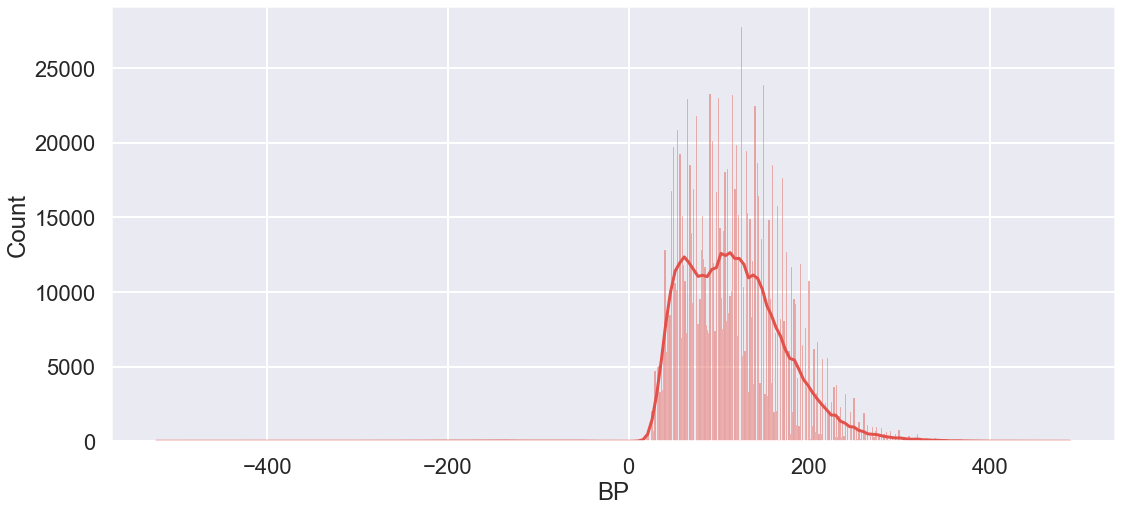

In [8]:
# Plotting BP
sns.histplot(data['BP'], kde=True)

## Observations
There seems to be a faint line below zero. This indicates that some athletes were not able to successfully complete a lift during the competition, hence a negative BP value has been placed.

Let's confirm our observation: 

In [9]:
data[data["BP"] < 0].shape

# there seems to be 1883 participants that failed all of their attempts! 

(1883, 37)

In [10]:
# Removing participants who failed all lifts
data.drop(data[data["BP"] < 0].index, inplace=True)

In [11]:
# checking 
data[data["BP"] < 0].shape

# no more yay! 

(0, 37)

Skewness:  0.723658606817627
Kurtotsis:  0.6185235162797449


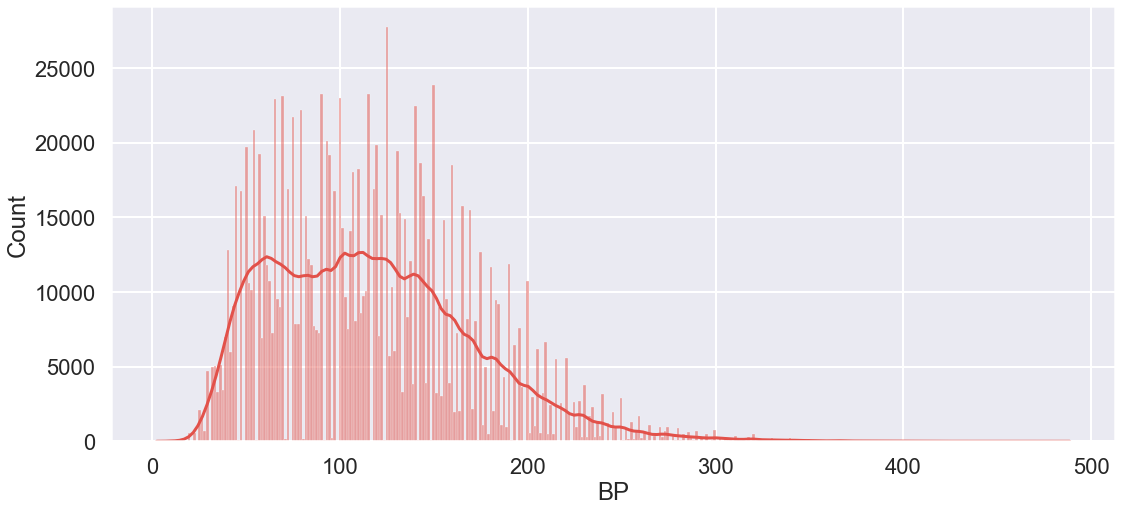

In [12]:
# visualizing the distribution of BP
sns.histplot(x='BP', data=data, kde=True)
print("Skewness: ", data["BP"].skew())
print("Kurtotsis: ",  data["BP"].kurt())

# Observations 
**Skewness:** The BP column seems to be right skewed (0.72 > 0.5 suggesting right skew). This makes sense since there are going to be some lifters that completely dominate the field and outperform all of the other average lifters. 

**Kurtosis:** BP seems to be on the lower end of kurtosis (0.61 < 3.00). This suggests that out of a random sample, it is highly likely to get a value from the average and highly unlikely to receive values from the extreme ends.


# Feature Selection 
### Numerical Variables 
Out of curiousity, let's start with the ten most highly correlated numerical features with BP for our machine learning model. This correlation will be measured by the pearson correlation coefficient value (R). 

### Categorical 
All categorical features will be considered. If there is noise in the model, further feature selection procedures will be taken to consider less categorical variables.

In [13]:
# heat map for 10 most positive correlated features with BP 
corr_largest = data.corr().nlargest(10, 'BP')['BP'].index

# heat map for 10 most negative correlated features with BP
corr_smallest = data.corr().nsmallest(10, 'BP')['BP'].index 

print("******10 Most Positively Correlated Features****** \n\n", corr_largest.values, '\n\n')
print("******10 Most Negatively Correlated Features****** \n\n", corr_smallest.values)

******10 Most Positively Correlated Features****** 

 ['BP' 'Best3SquatKg' 'Best3DeadliftKg' 'BodyweightKg' 'IPFPoints'
 'TotalKg' 'Deadlift1Kg' 'Bench1Kg' 'Squat1Kg' 'Glossbrenner'] 


******10 Most Negatively Correlated Features****** 

 ['Deadlift3Kg' 'Bench4Kg' 'Deadlift4Kg' 'Bench3Kg' 'Squat3Kg' 'Squat4Kg'
 'Age' 'Deadlift2Kg' 'Squat2Kg' 'McCulloch']


<AxesSubplot:>

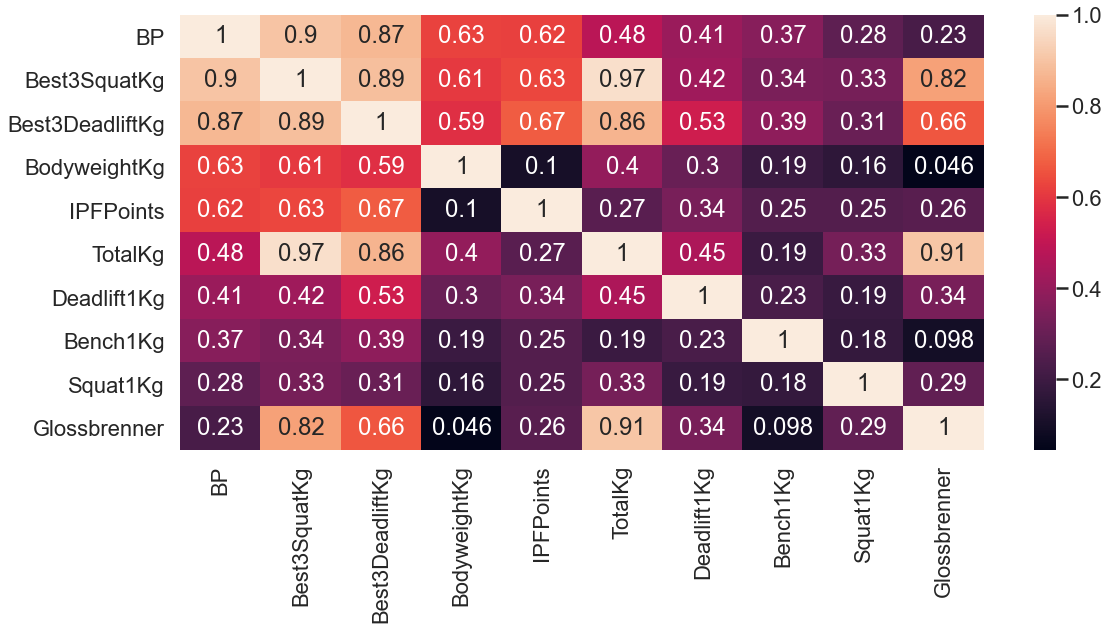

In [14]:
# contains only the 10 columns that have the highest correlation with best3BenchKg
cm_largest = data[corr_largest].corr()
cm_smallest = pd.concat([data[corr_smallest], data['BP']], axis=1).corr()
sns.heatmap(cm_largest, annot=True)

# Multicollinearity 
- Best3SquatKg is highly correlated with the features Best3DeadliftKg, TotalKg and Glossbrenner
- Best3DeadliftKg, TotalKg and Glossbrenner will be dropped since the same information is represented by Best3SquatKg which is the highest correlated variable out of the four. 
- we won't consider Bench1Kg, Squat1Kg nor Deadlift1Kg since we are already considering Best3xKg


## Numerical Features Being Considered
The numerical features that are being considered are the following:
- Best3SquatKg
- Best3DeadliftKg
- BodyweightKg
- IPFPoints 


In [15]:
old_data = data.copy()

In [16]:
# updating our dataset to only include the columns mentioned above 
data = old_data.loc[:, ['Best3SquatKg', 'Best3DeadliftKg', 'BodyweightKg', 'IPFPoints', 'BP']]

In [17]:
data.head()

# perfect! 

Best3SquatKg  Best3DeadliftKg  BodyweightKg  IPFPoints    BP
0         105.0            130.0          59.8     511.15  55.0
1         120.0            145.0          58.5     595.65  67.5
2           NaN              NaN          55.4     313.97  32.5
3         105.0            132.5          60.0     547.04  72.5
4         140.0            170.0         104.0     550.08  80.0

# Categorical Features
As mentioned, all categorical features will be considered except Name. It is obvious that a person's name will not be correlated with how much he/she can benchpress. For this reason, we can drop that column.

In [18]:
old_data.dtypes[old_data.dtypes == object].index

Index(['Name', 'Sex', 'Event', 'Equipment', 'AgeClass', 'Division',
       'WeightClassKg', 'Place', 'Tested', 'Country', 'Federation', 'Date',
       'MeetCountry', 'MeetState', 'MeetName'],
      dtype='object')

In [19]:
# updating our dataset to consider categorical features 
data = pd.concat([data, old_data[old_data.dtypes[old_data.dtypes == object].index]], axis=1)

In [20]:
# dropping the name column
data.drop('Name', axis=1, inplace=True)

In [21]:
data.dtypes

# perfect :)

Best3SquatKg       float64
Best3DeadliftKg    float64
BodyweightKg       float64
IPFPoints          float64
BP                 float64
Sex                 object
Event               object
Equipment           object
AgeClass            object
Division            object
WeightClassKg       object
Place               object
Tested              object
Country             object
Federation          object
Date                object
MeetCountry         object
MeetState           object
MeetName            object
dtype: object

# Missing Values 
if the number of missing values for a column is greater than 50% of all of the rows in the dataset, then the column will be dropped

In [22]:
(data.isnull().sum() / data.shape[0]) * 100

Best3SquatKg       27.517621
Best3DeadliftKg    23.936612
BodyweightKg        1.176457
IPFPoints          10.425046
BP                 10.353570
Sex                 0.000000
Event               0.000000
Equipment           0.000000
AgeClass           44.775729
Division            0.574686
WeightClassKg       0.936073
Place               0.000000
Tested             23.062307
Country            72.678444
Federation          0.000000
Date                0.000000
MeetCountry         0.000000
MeetState          33.883139
MeetName            0.000000
dtype: float64

In [23]:
# drop country because the missing values is just way too high (72%)
data.drop('Country', axis=1, inplace=True)

In [24]:
# filling in missing values with the median (mean isn't used because of right skew)
def fillna_median(cols, data):
    """Ensure that the columns given are numerical!!!"""
    for col in cols:
        data[col] = data[col].fillna(data[col].median())
    
    return data[data.dtypes[data.dtypes != 'object'].index].isnull().sum()

In [25]:
num_cols = data.dtypes[data.dtypes != 'object'].index
fillna_median(num_cols, data)

Best3SquatKg       0
Best3DeadliftKg    0
BodyweightKg       0
IPFPoints          0
BP                 0
dtype: int64

In [26]:
## filling the categorial data with the mode
def fillna_mode(cols, data):
    """Make sure the cols are type object!!! """
    for col in cols:
        data[col] = data[col].fillna(data[col].mode()[0])
    
    return data[data.dtypes[data.dtypes == 'object'].index].isnull().sum()

In [27]:
cat_cols = data.dtypes[data.dtypes == 'object'].index
fillna_mode(cat_cols, data)

Sex              0
Event            0
Equipment        0
AgeClass         0
Division         0
WeightClassKg    0
Place            0
Tested           0
Federation       0
Date             0
MeetCountry      0
MeetState        0
MeetName         0
dtype: int64

In [28]:
data.isnull().sum().max()

0

# Feature Engineering 
- Nominal variables will be Frequency encoded (each label replaced by the frequency that the label appears) 
- Ordinal variables will be label encoded

In [29]:
data.columns

Index(['Best3SquatKg', 'Best3DeadliftKg', 'BodyweightKg', 'IPFPoints', 'BP',
       'Sex', 'Event', 'Equipment', 'AgeClass', 'Division', 'WeightClassKg',
       'Place', 'Tested', 'Federation', 'Date', 'MeetCountry', 'MeetState',
       'MeetName'],
      dtype='object')

### Nominal Variables
- Equipment
- Age Class 
- Sex
- Event 
- MeetCountry 
- MeetState
- MeetName
- Tested

### Ordinal Variables 
- Place 
- Division

In [30]:
def freq_encoding(col):
    """For each column, replace the categorical value with its
       frequency in the column.
    """
    col_dict = col.value_counts().to_dict()
    return col.map(col_dict)

In [31]:
nominal_cols = ['Equipment', 'AgeClass', 'Sex', 'Event', 'MeetCountry', 'MeetState', 'MeetName', 'Tested', 'Place']

In [32]:
old_data = data.copy()
data[nominal_cols] = data[nominal_cols].apply(freq_encoding)

In [33]:
data.head()

Best3SquatKg  Best3DeadliftKg  BodyweightKg  IPFPoints    BP     Sex  \
0        105.00            130.0          59.8     511.15  55.0  362868   
1        120.00            145.0          58.5     595.65  67.5  362868   
2        167.83            184.0          55.4     313.97  32.5  362868   
3        105.00            132.5          60.0     547.04  72.5  362868   
4        140.00            170.0         104.0     550.08  80.0  362868   

     Event  Equipment  AgeClass Division WeightClassKg   Place   Tested  \
0  1072091     103542    880109     F-OR            60   94633  1421471   
1  1072091     103542    880109     F-OR            60  213496  1421471   
2   256494     466625     63722     F-OR            56  541905  1421471   
3  1072091     103542    136402     F-OR            60  134464  1421471   
4  1072091     103542     45600     F-OR           110  134464  1421471   

  Federation        Date  MeetCountry  MeetState  MeetName  
0    GPC-AUS  2018-10-27        40753      10630       471  
1    GPC-AUS  2018-10-27        40753      10630       471  
2    GPC-AUS  2018-10-27        40753      10630       471  
3    GPC-AUS  2018-10-27        40753      10630       471  
4    GPC-AUS  2018-10-27        40753      10630       471

In [34]:
data.Division.value_counts()

Open          345108
Boys          280231
Girls         118968
Juniors        50376
MR-O           29615
               ...  
166-181            1
FM-1 MP            1
RM 95-99           1
16-17 Teen         1
F-RA-A-Jr          1
Name: Division, Length: 4842, dtype: int64

In [35]:
# applying frequency encoding to two more columns 
data[["Division", "Federation"]] = data[["Division", "Federation"]].apply(freq_encoding)

In [36]:
data.head()

Best3SquatKg  Best3DeadliftKg  BodyweightKg  IPFPoints    BP     Sex  \
0        105.00            130.0          59.8     511.15  55.0  362868   
1        120.00            145.0          58.5     595.65  67.5  362868   
2        167.83            184.0          55.4     313.97  32.5  362868   
3        105.00            132.5          60.0     547.04  72.5  362868   
4        140.00            170.0         104.0     550.08  80.0  362868   

     Event  Equipment  AgeClass  Division WeightClassKg   Place   Tested  \
0  1072091     103542    880109      3021            60   94633  1421471   
1  1072091     103542    880109      3021            60  213496  1421471   
2   256494     466625     63722      3021            56  541905  1421471   
3  1072091     103542    136402      3021            60  134464  1421471   
4  1072091     103542     45600      3021           110  134464  1421471   

   Federation        Date  MeetCountry  MeetState  MeetName  
0        8157  2018-10-27        40753      10630       471  
1        8157  2018-10-27        40753      10630       471  
2        8157  2018-10-27        40753      10630       471  
3        8157  2018-10-27        40753      10630       471  
4        8157  2018-10-27        40753      10630       471

data.columns

In [37]:
data['Date'] = pd.to_datetime(data['Date'])

In [38]:
# year will not be included in the model since we will want to predict the future 
# the month data will be useful
data['Date'] = data['Date'].dt.month

In [39]:
# we will label encode the WeightClassKg column since there it is an ordinal column 
encoder = LabelEncoder()
data['WeightClassKg'] = encoder.fit_transform(data['WeightClassKg'])

# Splitting Dataset
In this section, we will split our dataset into training and testing sections. 

In [40]:
# placing bp at the final column
bp = data.pop('BP')
data['BP'] = bp

In [41]:
# shrinking the dataset to lower training time for models 
shrinked_data = data.iloc[:500000, :]

In [42]:
X = shrinked_data.iloc[:, :-1]
y = shrinked_data.iloc[:, -1]

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)

# Standardization 
- all columns (including categorical columns) will be standardized in order for the range for all of the features to be similar to each other.

In [44]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [45]:
X_train.describe()

# Great! All observartions have a unit variance and a mean of approximately 0! 

Best3SquatKg  Best3DeadliftKg  BodyweightKg     IPFPoints  \
count  4.000000e+05     4.000000e+05  4.000000e+05  4.000000e+05   
mean  -1.320355e-16     2.063259e-15 -5.112212e-16  4.662901e-16   
std    1.000001e+00     1.000001e+00  1.000001e+00  1.000001e+00   
min   -1.060664e+01    -1.050355e+01 -3.050115e+00 -4.632432e+00   
25%   -5.824607e-01    -6.042740e-01 -7.658279e-01 -7.056282e-01   
50%   -1.692128e-01    -7.125537e-02 -1.346548e-01  3.369345e-02   
75%    4.920204e-01     4.778130e-01  6.516890e-01  4.986470e-01   
max    7.227707e+00     5.633565e+00  6.998825e+00  7.507064e+00   

                Sex         Event     Equipment      AgeClass      Division  \
count  4.000000e+05  4.000000e+05  4.000000e+05  4.000000e+05  4.000000e+05   
mean   1.831744e-15 -5.563325e-15 -2.860830e-15  1.596286e-15 -2.661492e-15   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -3.071580e+00 -2.931339e+00 -3.302345e+00 -2.060396e+00 -1.594076e+00   
25%    3.255654e-01  4.240047e-01  4.951695e-01  5.329120e-01 -1.404352e+00   
50%    3.255654e-01  4.240047e-01  4.951695e-01  5.329120e-01  4.887568e-01   
75%    3.255654e-01  4.240047e-01  4.951695e-01  5.329120e-01  4.887568e-01   
max    3.255654e-01  4.240047e-01  4.951695e-01  5.329120e-01  9.709604e-01   

       WeightClassKg         Place    Tested    Federation          Date  \
count   4.000000e+05  4.000000e+05  400000.0  4.000000e+05  4.000000e+05   
mean   -7.527806e-16  1.269247e-15       0.0  3.619910e-16 -6.902206e-15   
std     1.000001e+00  1.000001e+00       0.0  1.000001e+00  1.000001e+00   
min    -1.818539e+00 -1.046159e+00       0.0 -1.207380e+00 -8.720445e-01   
25%    -1.184651e+00 -7.791893e-01       0.0 -1.052362e+00 -8.720445e-01   
50%     1.551567e-01 -3.896591e-01       0.0  9.610551e-01 -5.847173e-01   
75%     8.898900e-01  1.599669e+00       0.0  9.610551e-01  5.645915e-01   
max     1.379712e+00  1.599669e+00       0.0  9.610551e-01  2.288555e+00   

        MeetCountry     MeetState      MeetName  
count  4.000000e+05  4.000000e+05  4.000000e+05  
mean   7.191950e-15 -6.676432e-16  1.919423e-17  
std    1.000001e+00  1.000001e+00  1.000001e+00  
min   -1.815169e+00 -1.683153e+00 -2.936202e-01  
25%   -1.579545e+00 -1.605739e+00 -2.659292e-01  
50%    5.807599e-01  6.073300e-01 -2.354436e-01  
75%    5.807599e-01  6.073300e-01 -1.269658e-01  
max    5.807599e-01  6.073300e-01  7.989563e+00

In [46]:
X_train.to_csv("data/training_data/X_train.csv", index=False)
X_test.to_csv("data/testing_data/X_test.csv", index=False)
y_train.to_csv("data/training_data/y_train.csv", index=False)
y_test.to_csv("data/testing_data/y_test.csv", index=False)